# Preliminary results on BLM tests during last RHIC Au+Au run 

Loading libraries and definitions.

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from datetime import datetime
import glob

# definitions
blm_col = {1:'blue', 2:'red', 3:'darkgreen'}
ch_label = {1:'CVD BLM', 2:'Plastic BLM', 3:'Quartz BLM'}


## Collecting data files and make DataFrames:
- CSVs with peaks from BLM:
    - open
    - concatinate
    - clean

In [177]:
# Find all CSV files in the folder
csv_files = glob.glob('../Data/peaks_*.csv')
# Read and concatenate CSVs
dfs = [pd.read_csv(f) for f in csv_files]
df_ini = pd.concat(dfs, ignore_index=True)
date_string = '2025_0716-0724' 

use_dates = '2025_0716-0724'

# Preview the first few rows
print(df_ini.head())

# Array-like columns
array_cols = ['peak_indicies', 'peak_heights', 'widths', 'dist_to_revsig', 'integrals']

# Parse the strings into lists
def parse_array_str(s):
    if not isinstance(s, str):
        return []
    s = s.strip('[]').strip()
    if not s:
        return []
    return s.split()

for col in array_cols:
    df_ini[col] = df_ini[col].apply(parse_array_str)

# Clean and align arrays row-by-row
def clean_row(row):
    arrays = {col: row[col] for col in array_cols}
    
    # Mark valid indices based on whether 'peak_indicies' are integers
    valid_indices = []
    for i, val in enumerate(arrays['peak_indicies']):
        try:
            int(val)
            valid_indices.append(i)
        except ValueError:
            continue

    # Now filter each array to keep only valid indices
    for col in array_cols:
        arr = arrays[col]
        arrays[col] = [arr[i] for i in valid_indices if i < len(arr)]

    # Optional: convert to int/float
    try:
        arrays['peak_indicies'] = [int(x) for x in arrays['peak_indicies']]
    except:
        arrays['peak_indicies'] = []
    try:
        arrays['peak_heights'] = [float(x) for x in arrays['peak_heights']]
        arrays['widths'] = [float(x) for x in arrays['widths']]
        arrays['dist_to_revsig'] = [float(x) for x in arrays['dist_to_revsig']]
        arrays['integrals'] = [float(x) for x in arrays['integrals']]
    except:
        pass  # You can choose to drop or log here

    # Return updated row
    for col in array_cols:
        row[col] = arrays[col]
    return row

# Apply row cleaning
df_ini = df_ini.apply(clean_row, axis=1)

# Explode each of those columns simultaneously
# First, ensure that each list in array columns has the same length per row
assert all(
    (df_ini[array_cols[0]].str.len() == df_ini[col].str.len()).all()
    for col in array_cols[1:]
), "Array columns have differing lengths within rows!"

# Explode the dataframe by repeating rows for each element in the arrays
df = df_ini.explode(array_cols).reset_index(drop=True)

# Cleaning bad timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
bad_timestamps = df[df['timestamp'].isna()]
print("Bad timing: ",bad_timestamps)

# Convert peak_heights to numeric if it's string/object
df['peak_heights'] = pd.to_numeric(df['peak_heights'], errors='coerce')

# Group by channel
df['dist_to_revsig_ns'] = -1*df['dist_to_revsig'] * 1.0/df['sample_rate'] * 1e9

print(df.head)

   ch peak_indicies  peak_heights        widths dist_to_revsig     integrals  \
0   1      [500000]  [0.04115226]        [2.15]        [-6147]  [0.05761317]   
1   1      [500000]  [0.04526749]  [2.09090909]        [-6466]  [0.06378601]   
2   1      [500000]  [0.14403292]  [1.60427807]        [-8347]  [0.18106996]   
3   1      [500000]  [0.33744856]  [1.76899264]        [-3148]  [0.45473251]   
4   1      [500000]  [0.04526749]  [1.88636364]        [-1431]  [0.05761317]   

                    timestamp  sample_rate  buffer_size  trigger_chn  \
0  2025-07-22T00:00:19.215117  750000000.0      1000000            1   
1  2025-07-22T00:00:20.187795  750000000.0      1000000            1   
2  2025-07-22T00:00:20.815826  750000000.0      1000000            1   
3  2025-07-22T00:00:21.618271  750000000.0      1000000            1   
4  2025-07-22T00:00:22.243110  750000000.0      1000000            1   

   trigger_level  
0           0.04  
1           0.04  
2           0.04  
3         

- Data files from beam monitoring

In [178]:
#------------ Read RHIC data with combining date/time
# Get beam current data
df_current = pd.read_csv(
    f'/Users/evgenyshulga/Work/EIC/BLM/BEAM_RHIC_DATA/rhic_data_beamcurrent_{use_dates}.dat',
    sep=r'\s+',
    comment='#',
    header=None,
    names=['Date', 'Time', 'bluDCCTtotal', 'yelDCCTtotal', 'RhicState', 'Fill']
)
df_start = pd.read_csv(
    f'/Users/evgenyshulga/Work/EIC/BLM/BEAM_RHIC_DATA/rhic_data_startramp_{use_dates}.dat',
    sep=r'\s+',
    comment='#',
    header=None,
    names=['Date', 'Time', 'Flag']
)
df_end = pd.read_csv(
    f'/Users/evgenyshulga/Work/EIC/BLM/BEAM_RHIC_DATA/rhic_data_endramp_{use_dates}.dat',
    sep=r'\s+',
    comment='#',
    header=None,
    names=['Date', 'Time', 'Flag']
)
# Get BLM data
df_blm = pd.read_csv(
    f'/Users/evgenyshulga/Work/EIC/BLM/BEAM_RHIC_DATA/rhic_data_blm_{use_dates}.dat',
    sep=r'\s+',
    comment='#',
    header=None,
    names=['Date', 'Time', 'Array', 'Counts1', 'Counts2']
)

# Get beam abort data
df_abort = pd.read_csv(
    f'/Users/evgenyshulga/Work/EIC/BLM/BEAM_RHIC_DATA/rhic_data_abort_{use_dates}.dat',
    sep=r'\s+',
    comment='#',
    header=None,
    names=['Date', 'Time', 'Abort']
)

# Get blue beam emitx data
df_blue_nemitx = pd.read_csv(
    f'/Users/evgenyshulga/Work/EIC/BLM/BEAM_RHIC_DATA/rhic_data_blue_emitx_{use_dates}.dat',
    sep=r'\s+',
    comment='#',
    header=None,
    names=['Date', 'Time', 'nEmit']
)

# Get blue beam emity data
df_blue_nemity = pd.read_csv(
    f'/Users/evgenyshulga/Work/EIC/BLM/BEAM_RHIC_DATA/rhic_data_blue_emity_{use_dates}.dat',
    sep=r'\s+',
    comment='#',
    header=None,
    names=['Date', 'Time', 'nEmit']
)

# Get yellow beam emitx data
df_yellow_nemitx = pd.read_csv(
    f'/Users/evgenyshulga/Work/EIC/BLM/BEAM_RHIC_DATA/rhic_data_yellow_emitx_{use_dates}.dat',
    sep=r'\s+',
    comment='#',
    header=None,
    names=['Date', 'Time', 'nEmit']
)

# Get yellow beam emity data
df_yellow_nemity = pd.read_csv(
    f'/Users/evgenyshulga/Work/EIC/BLM/BEAM_RHIC_DATA/rhic_data_yellow_emity_{use_dates}.dat',
    sep=r'\s+',
    comment='#',
    header=None,
    names=['Date', 'Time', 'nEmit']
)

# Combine and convert with datetime.strptime
df_current['Timestamp'] = df_current.apply(lambda row: datetime.strptime(f"{row['Date']} {row['Time']}", '%m/%d/%Y %H:%M:%S'),axis=1)
df_abort['Timestamp'] = df_abort.apply(lambda row: datetime.strptime(f"{row['Date']} {row['Time']}", '%m/%d/%Y %H:%M:%S'),axis=1)
df_blm['Timestamp'] = df_blm.apply(lambda row: datetime.strptime(f"{row['Date']} {row['Time']}", '%m/%d/%Y %H:%M:%S'),axis=1)
df_blue_nemitx['Timestamp'] = df_blue_nemitx.apply(lambda row: datetime.strptime(f"{row['Date']} {row['Time']}", '%m/%d/%Y %H:%M:%S'),axis=1)
df_blue_nemity['Timestamp'] = df_blue_nemity.apply(lambda row: datetime.strptime(f"{row['Date']} {row['Time']}", '%m/%d/%Y %H:%M:%S'),axis=1)
df_yellow_nemitx['Timestamp'] = df_yellow_nemitx.apply(lambda row: datetime.strptime(f"{row['Date']} {row['Time']}", '%m/%d/%Y %H:%M:%S'),axis=1)
df_yellow_nemity['Timestamp'] = df_yellow_nemity.apply(lambda row: datetime.strptime(f"{row['Date']} {row['Time']}", '%m/%d/%Y %H:%M:%S'),axis=1)
df_start['Timestamp'] = df_start.apply(lambda row: datetime.strptime(f"{row['Date']} {row['Time']}", '%m/%d/%Y %H:%M:%S'),axis=1)
df_end['Timestamp'] = df_end.apply(lambda row: datetime.strptime(f"{row['Date']} {row['Time']}", '%m/%d/%Y %H:%M:%S'),axis=1)


# Drop the original columns and reorder
df_current.drop(columns=['Date', 'Time'], inplace=True)
df_current = df_current[['Timestamp', 'bluDCCTtotal', 'yelDCCTtotal', 'RhicState', 'Fill']]
df_blm.drop(columns=['Date', 'Time', 'Array'], inplace=True)
df_blm = df_blm[['Timestamp', 'Counts1', 'Counts2']]
df_abort.drop(columns=['Date', 'Time'], inplace=True)
df_abort = df_abort[['Timestamp', 'Abort']]
df_blue_nemitx.drop(columns=['Date', 'Time'], inplace=True)
df_blue_nemitx = df_blue_nemitx[['Timestamp', 'nEmit']]
df_blue_nemity.drop(columns=['Date', 'Time'], inplace=True)
df_blue_nemity = df_blue_nemity[['Timestamp', 'nEmit']]
df_yellow_nemitx.drop(columns=['Date', 'Time'], inplace=True)
df_yellow_nemitx = df_yellow_nemitx[['Timestamp', 'nEmit']]
df_yellow_nemity.drop(columns=['Date', 'Time'], inplace=True)
df_yellow_nemity = df_yellow_nemity[['Timestamp', 'nEmit']]
df_start.drop(columns=['Date', 'Time'], inplace=True)
df_start = df_start[['Timestamp', 'Flag']]
df_end.drop(columns=['Date', 'Time'], inplace=True)
df_end = df_end[['Timestamp', 'Flag']]


## Analysing Data

Rate of the dimond detectors was few Hz triggering was applied for signals from the detectors, not to collect to many empty events. Each channel was read for 2 min consequently, thus to calculate average rate averaging should be weather in 2 min range or more than 6 minutes and devided by 3 as there are 3 channels.

In [179]:
avg_min = 6 #data taking is N min each, should be >6 minutes
# Count occurrences per N minutes for each channel
counts = df.groupby([
    pd.Grouper(key='timestamp', freq=f'{avg_min}min'),  # round timestamps to avg_min bins
    'ch'
]).size().reset_index(name='count')
# Group and compute mean peak_heights
avg_heights = df.groupby([
    pd.Grouper(key='timestamp', freq=f'{avg_min}min'),
    'ch'
])['peak_heights'].mean().reset_index(name='avg_peak_height')

# Merge rate and average height by time + channel
combined = pd.merge(counts, avg_heights, on=['timestamp', 'ch'], how='left')

# Optional: calculate rate per minute (divide by avg_min)
counts['rate_per_min'] = counts['count'] / (avg_min/3)
counts['rate_per_sec'] = counts['count'] / (avg_min/3*60)
# Optional: calculate rate per minute (divide by avg_min)
combined['rate_per_min'] = combined['count'] / (avg_min/3)
combined['rate_per_sec'] = combined['count'] / (avg_min/3*60)

Lets see average rate versus amplitude:

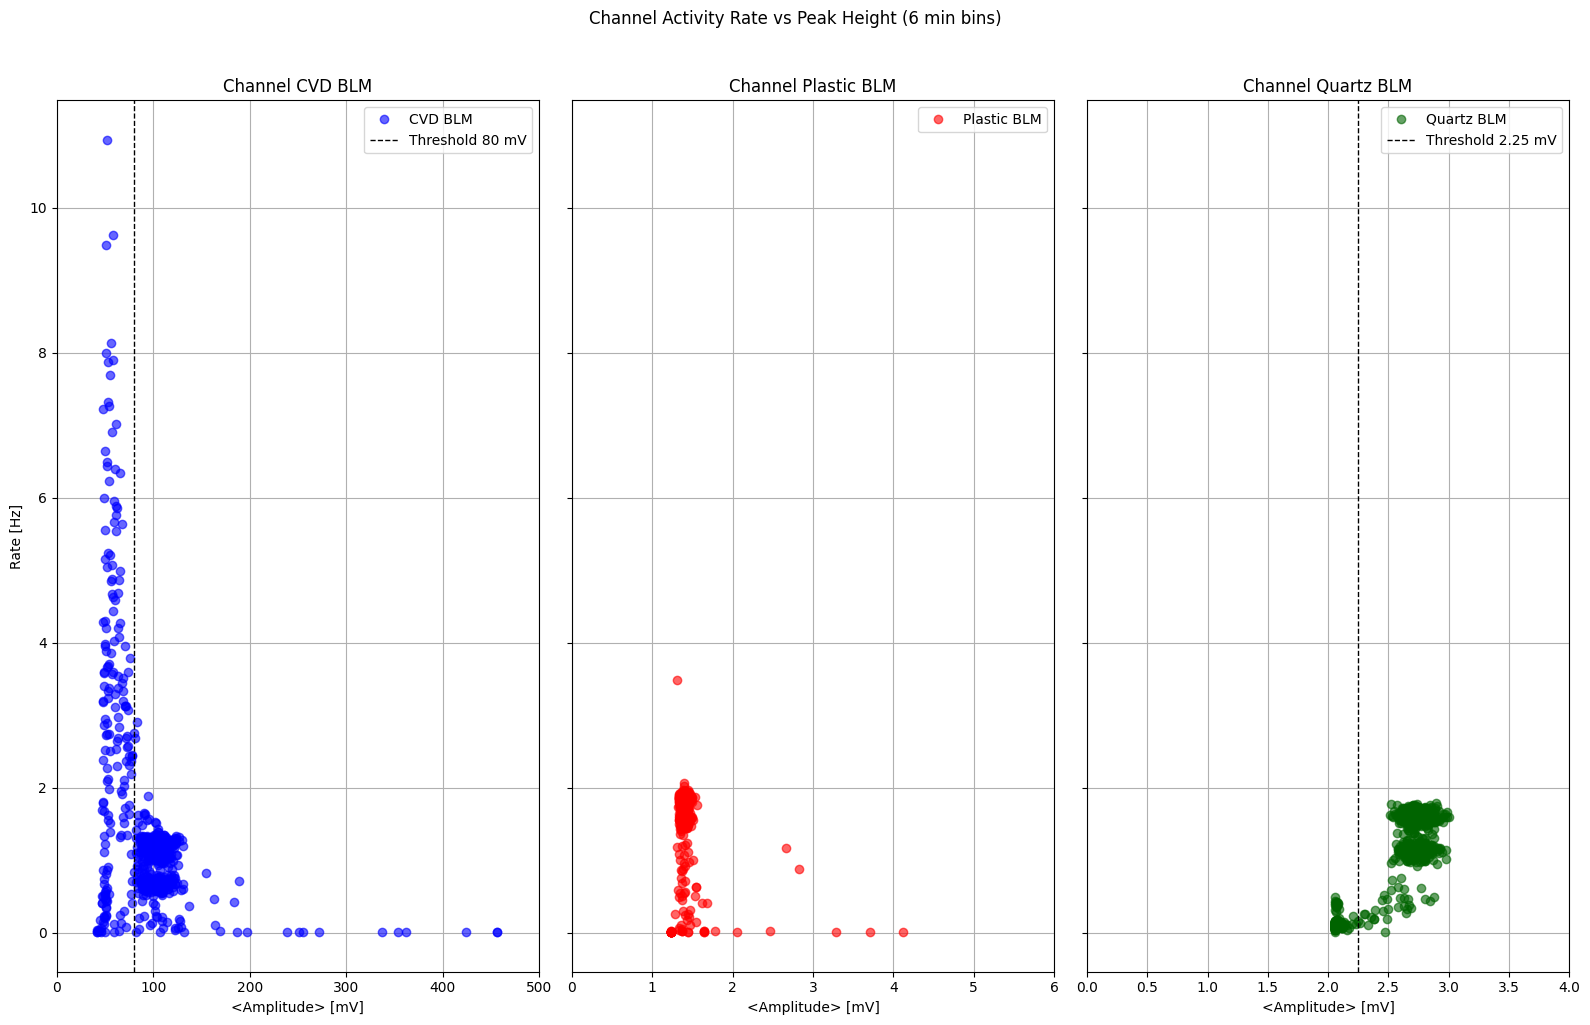

In [180]:
channels = combined['ch'].unique()
# Plotting the rate per second for each channel
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
xlim = {1:500, 2:6, 3:4}  # Set x-axis limits for each channel
for i, ch in enumerate(sorted(channels)):
    df_ch = combined[(combined['ch'] == ch) & (combined['rate_per_sec'] > 0)]
    axs[i].plot(1000*df_ch['avg_peak_height'], df_ch['rate_per_sec'],
                label=ch_label[ch],
                marker='o', linestyle='', color=blm_col[ch], alpha=0.6)

    axs[i].set_xlabel('<Amplitude> [mV]')    
    axs[i].set_title(f'Channel {ch_label[ch]}')
    #axs[i].set_xscale('log')
    axs[i].set_xlim(0, xlim[ch])  # Set x-axis limit to 0-1000 mV
    axs[i].grid(True)
    #axs[i].legend()

axs[0].set_ylabel('Rate [Hz]')
# Draw vertical line at 80 mV on the first axis (axs[0])
axs[0].axvline(x=80, color='black', linestyle='--', linewidth=1, label='Threshold 80 mV')
axs[0].legend()
axs[1].legend()

# Draw vertical line at 2.25 on the last axis (axs[-1])
axs[-1].axvline(x=2.25, color='black', linestyle='--', linewidth=1, label='Threshold 2.25 mV')
axs[-1].legend()

plt.suptitle(f'Channel Activity Rate vs Peak Height ({avg_min} min bins)', y=1.02)
plt.tight_layout()
plt.savefig(f"./Plots/peak_heights_vs_rate_by_channel_{date_string}.png", dpi=300)
plt.show()

CVD diamond based BLM is showing high rate at low amplitudes some times, maybe it is related to collision background. Thus, we will implement lower threshold for CVD BLM at 80 mV and 2.25 mv for Quartz BLM. There is a structure in the rate, not clear what tis the source yet

In [181]:
df = df[
    ((df['peak_heights'] > 0.085) & (df['ch'] == 1)) |
    ((df['peak_heights'] > 0.00225) & (df['ch'] == 3)) |
    ((df['peak_heights'] > 0.0012) & (df['ch'] == 2))
]

Rate versus time:

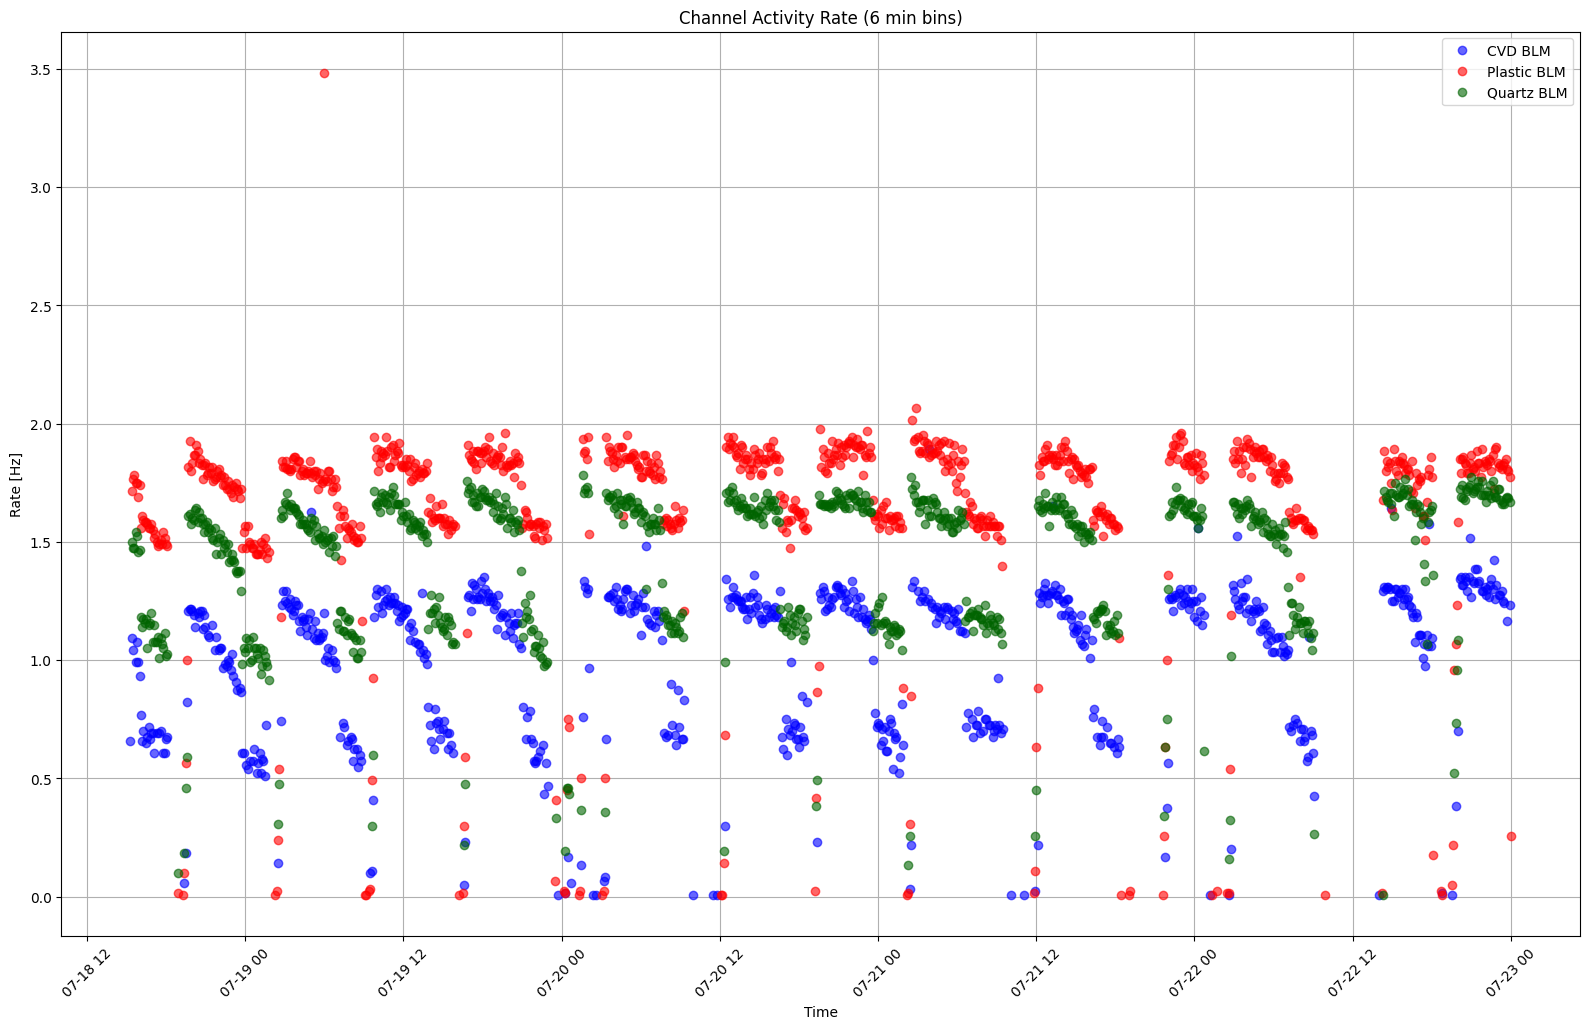

In [182]:
plt.figure(figsize=(16, 10))
for ch in combined['ch'].unique():
    if ch==1:
        df_ch = combined[(counts['ch'] == ch) & (combined['rate_per_sec'] > 0) & (combined['avg_peak_height'] > 0.085)]
    if ch==2:
        df_ch = combined[(counts['ch'] == ch) & (combined['rate_per_sec'] > 0) & (combined['avg_peak_height'] > 0.0012)]
    if ch==3:
        df_ch = combined[(counts['ch'] == ch) & (combined['rate_per_sec'] > 0) & (combined['avg_peak_height'] > 0.00225)]
    plt.plot(df_ch['timestamp'], df_ch['rate_per_sec'], label=ch_label[ch], marker='o', linestyle='', color=blm_col[ch],  alpha=0.6)

plt.xlabel('Time')
plt.ylabel('Rate [Hz]')
plt.title(f'Channel Activity Rate ({avg_min} min bins)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig(f"./Plots/rate_vs_time_{date_string}.png", dpi=300)

plt.show()

Peak Height with respect to the beam revolution trigger:

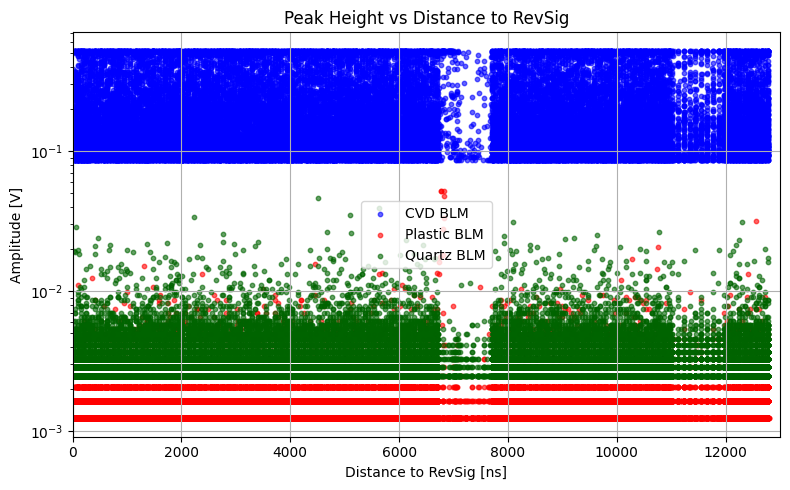

In [183]:
# Plot
plt.figure(figsize=(8, 5))
for ch in combined['ch'].unique():        
    plt.scatter(df[df['ch']==ch]['dist_to_revsig_ns'], df[df['ch']==ch]['peak_heights'], color=blm_col[ch], label=ch_label[ch], s=10, alpha=0.6)
plt.xlabel('Distance to RevSig [ns]')
plt.ylabel('Amplitude [V]')
plt.title('Peak Height vs Distance to RevSig')
plt.grid(True)
plt.xlim(-1, 13000)
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/amp_vs_revsig_{date_string}.png", dpi=300)

plt.show()


Amplitude versus time:

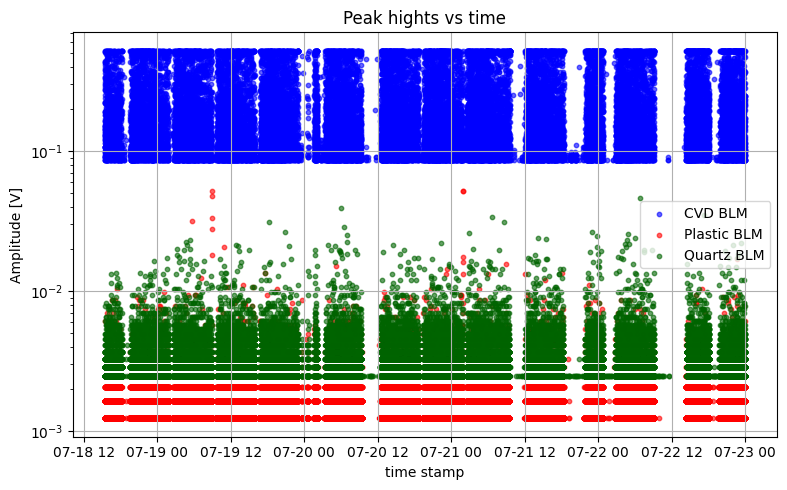

In [184]:
plt.figure(figsize=(8, 5))
for ch in combined['ch'].unique():        
    plt.scatter(df[df['ch']==ch]['timestamp'], df[df['ch']==ch]['peak_heights'], color=blm_col[ch], label=ch_label[ch], s=10, alpha=0.6)
plt.xlabel('time stamp')
plt.ylabel('Amplitude [V]')
plt.title('Peak hights vs time')
plt.grid(True)
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/amp_vs_time_{date_string}.png", dpi=300)

plt.show()


In [185]:
# Ensure Timestamp is datetime and set index
df_current['Timestamp'] = pd.to_datetime(df_current['Timestamp'])
df_current = df_current.set_index('Timestamp')

current = df_current['bluDCCTtotal']
intervals = []

i = 0
while i < len(current) - 1:
    # Find first drop below or equal to 200 from above
    if current.iloc[i] > 210 and current.iloc[i + 1] <= 210:
        drop_200_time = current.index[i + 1]

        # Now look forward for drop below or equal to 50
        j = i + 1
        while j < len(current) and current.iloc[j] > 50:
            j += 1
        if j < len(current):
            drop_50_time = current.index[j]
            intervals.append(
                (drop_200_time,
                drop_50_time)
            )
            i = j  # skip ahead to after this drop
        else:
            break
    else:
        i += 1


To exclude contribution from unstable beam, selecting certain intensity intervals: 50<Intensity<210

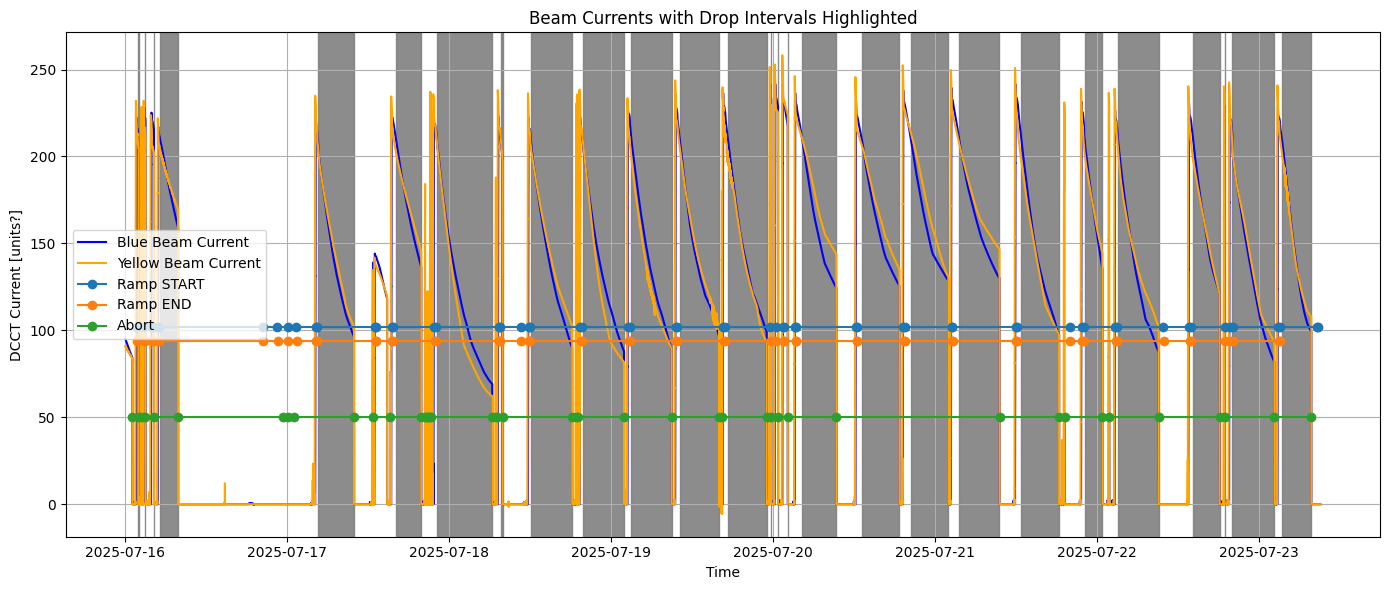

In [186]:
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(df_current.index, df_current['bluDCCTtotal'], label='Blue Beam Current', color='blue')
plt.plot(df_current.index, df_current['yelDCCTtotal'], label='Yellow Beam Current', color='orange')
plt.plot(df_start['Timestamp'], df_start['Flag'], label='Ramp START', marker='o', linestyle='-')
plt.plot(df_end['Timestamp'], df_end['Flag'], label='Ramp END', marker='o', linestyle='-')
plt.plot(df_abort['Timestamp'], df_abort['Abort'], label='Abort', marker='o', linestyle='-')
for start, end in intervals:#overlapping_intervals:
    plt.axvspan(start, end, color='gray', alpha=0.9)

# Convert list of dicts to DataFrame
intervals_df = pd.DataFrame(intervals,columns=['start','end'])

# Save to CSV
intervals_df.to_csv(f'stable_beam_intervals_{use_dates}.csv', index=False)

plt.xlabel("Time")
plt.ylabel("DCCT Current [units?]")
plt.title("Beam Currents with Drop Intervals Highlighted")
#plt.ylim(1e-2, 300)

#plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("f'stable_beam_intervals_{use_dates}.png", dpi=300)

plt.show()

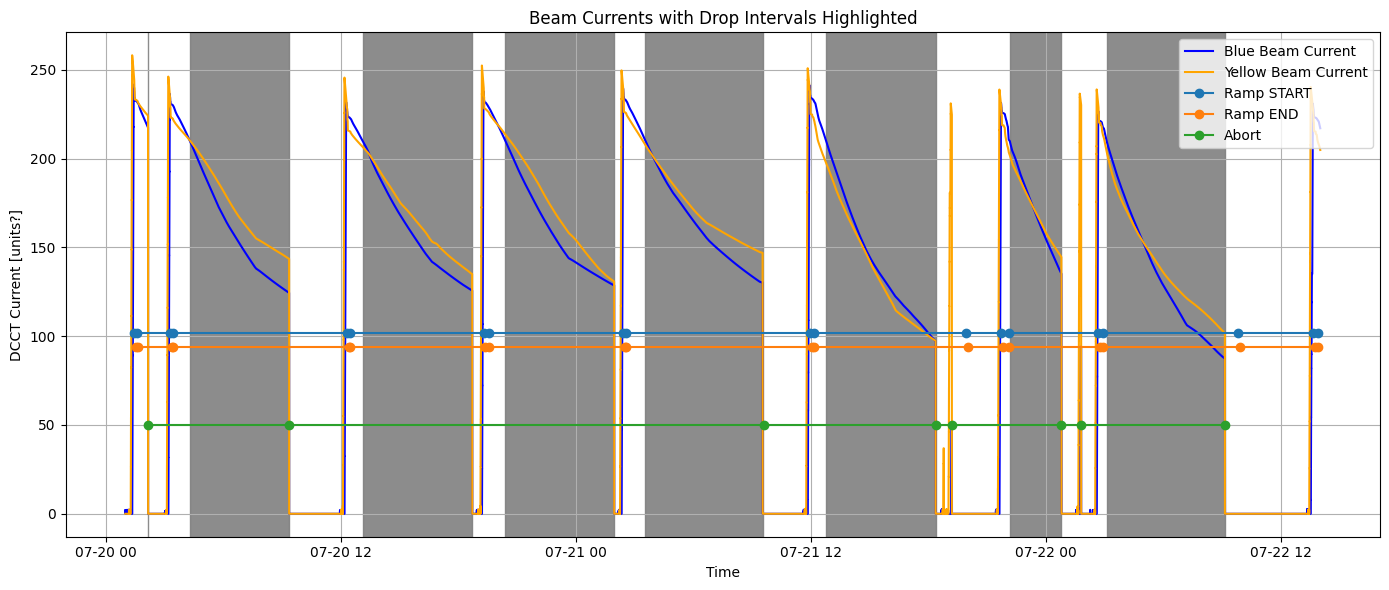

In [187]:
start_time = pd.to_datetime("2025-07-20 01:00:00")
end_time = pd.to_datetime("2025-07-22 14:00:00")
# Plotting
plt.figure(figsize=(14, 6))
selection_1 = ((df_current.index >= start_time) & (df_current.index <= end_time))
selection_start = ((df_start['Timestamp'] >= start_time) & (df_start['Timestamp'] <= end_time))
selection_end = ((df_end['Timestamp'] >= start_time) & (df_end['Timestamp'] <= end_time))
selection_abort = ((df_abort['Timestamp'] >= start_time) & (df_abort['Timestamp'] <= end_time))

plt.plot(df_current[selection_1].index, df_current[selection_1]['bluDCCTtotal'], label='Blue Beam Current', color='blue')
plt.plot(df_current[selection_1].index, df_current[selection_1]['yelDCCTtotal'], label='Yellow Beam Current', color='orange')
plt.plot(df_start[selection_start]['Timestamp'], df_start[selection_start]['Flag'], label='Ramp START', marker='o', linestyle='-')
plt.plot(df_end[selection_end]['Timestamp'], df_end[selection_end]['Flag'], label='Ramp END', marker='o', linestyle='-')
plt.plot(df_abort[selection_abort]['Timestamp'], df_abort[selection_abort]['Abort'], label='Abort', marker='o', linestyle='-')
for start, end in intervals:#overlapping_intervals:
    if start >= start_time and end <= end_time:
        plt.axvspan(start, end, color='gray', alpha=0.9)

## Convert list of dicts to DataFrame
#intervals_df = pd.DataFrame(intervals,columns=['start','end'])
#
## Save to CSV
#intervals_df.to_csv(f'stable_beam_intervals_{use_dates}.csv', index=False)

plt.xlabel("Time")
plt.ylabel("DCCT Current [units?]")
plt.title("Beam Currents with Drop Intervals Highlighted")
#plt.ylim(1e-2, 300)

#plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("f'stable_beam_intervals_{use_dates}.png", dpi=300)

plt.show()

Using only stable beam conditions:

In [191]:
# Load your main data (assuming it's already in variable df)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Load the intervals CSV
intervals = pd.read_csv(f'./stable_beam_intervals_{use_dates}.csv')
intervals['start'] = pd.to_datetime(intervals['start'])
intervals['end'] = pd.to_datetime(intervals['end'])

# Create a mask to keep only rows in df within any interval
mask = pd.Series(False, index=df.index)

for _, row in intervals.iterrows():
    mask |= (df['timestamp'] >= row['start']) & (df['timestamp'] <= row['end'])

# Filtered DataFrame
df = df[mask].copy()

#print(df_filtered)

# Flatten the dist_to_revsig values (assumes each cell is a list)
all_distances_1_filtered = df[(df['ch']==1 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)
all_distances_2_filtered = df[(df['ch']==2 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)
all_distances_3_filtered = df[(df['ch']==3 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)


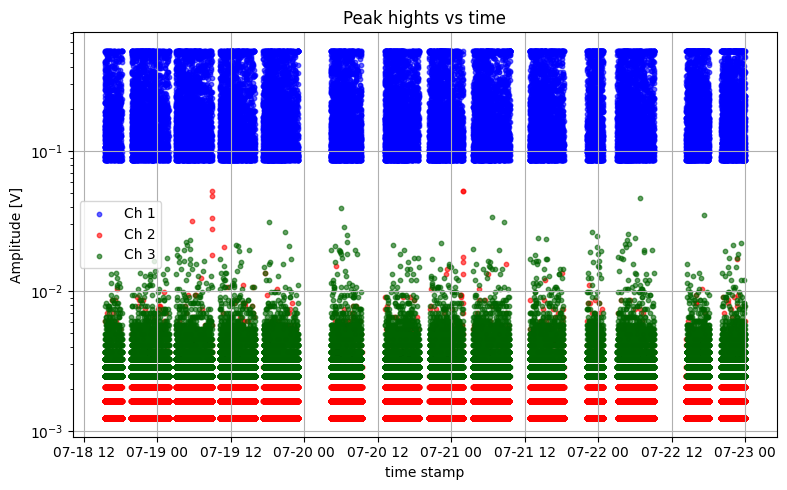

In [192]:
plt.figure(figsize=(8, 5))
        
plt.scatter(df_filtered[df_filtered['ch']==1]['timestamp'], df_filtered[df_filtered['ch']==1]['peak_heights'], color='blue', label=f"Ch 1", s=10, alpha=0.6)
plt.scatter(df_filtered[df_filtered['ch']==2]['timestamp'], df_filtered[df_filtered['ch']==2]['peak_heights'], color='red', label=f"Ch 2", s=10, alpha=0.6)
plt.scatter(df_filtered[df_filtered['ch']==3]['timestamp'], df_filtered[df_filtered['ch']==3]['peak_heights'], color='darkgreen', label=f"Ch 3", s=10, alpha=0.6)
plt.xlabel('time stamp')
plt.ylabel('Amplitude [V]')
plt.title('Peak hights vs time')
plt.grid(True)
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/amp_vs_time_{date_string}.png", dpi=300)

plt.show()

Amplitude distribution:

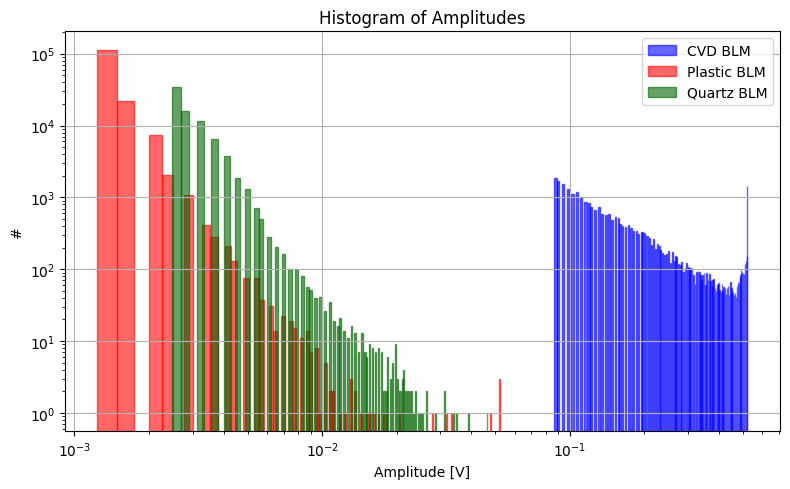

In [193]:
# Plot histogram
plt.figure(figsize=(8, 5))
for ch in combined['ch'].unique():        
    plt.hist(df[df['ch']==ch]['peak_heights'], bins=200, color=blm_col[ch], edgecolor=blm_col[ch], label=ch_label[ch], alpha=0.6)

plt.xlabel('Amplitude [V]')
plt.ylabel('#')
plt.title('Histogram of Amplitudes')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/amp_{date_string}.png", dpi=300)
plt.show()

To show time from beam revolution trigger to signal in the detector need to extract all distances

In [194]:
# Flatten the dist_to_revsig values (assumes each cell is a list)
all_distances_1 = df[(df['ch']==1 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)
all_distances_2 = df[(df['ch']==2 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)
all_distances_3 = df[(df['ch']==3 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)


Plot the timing:

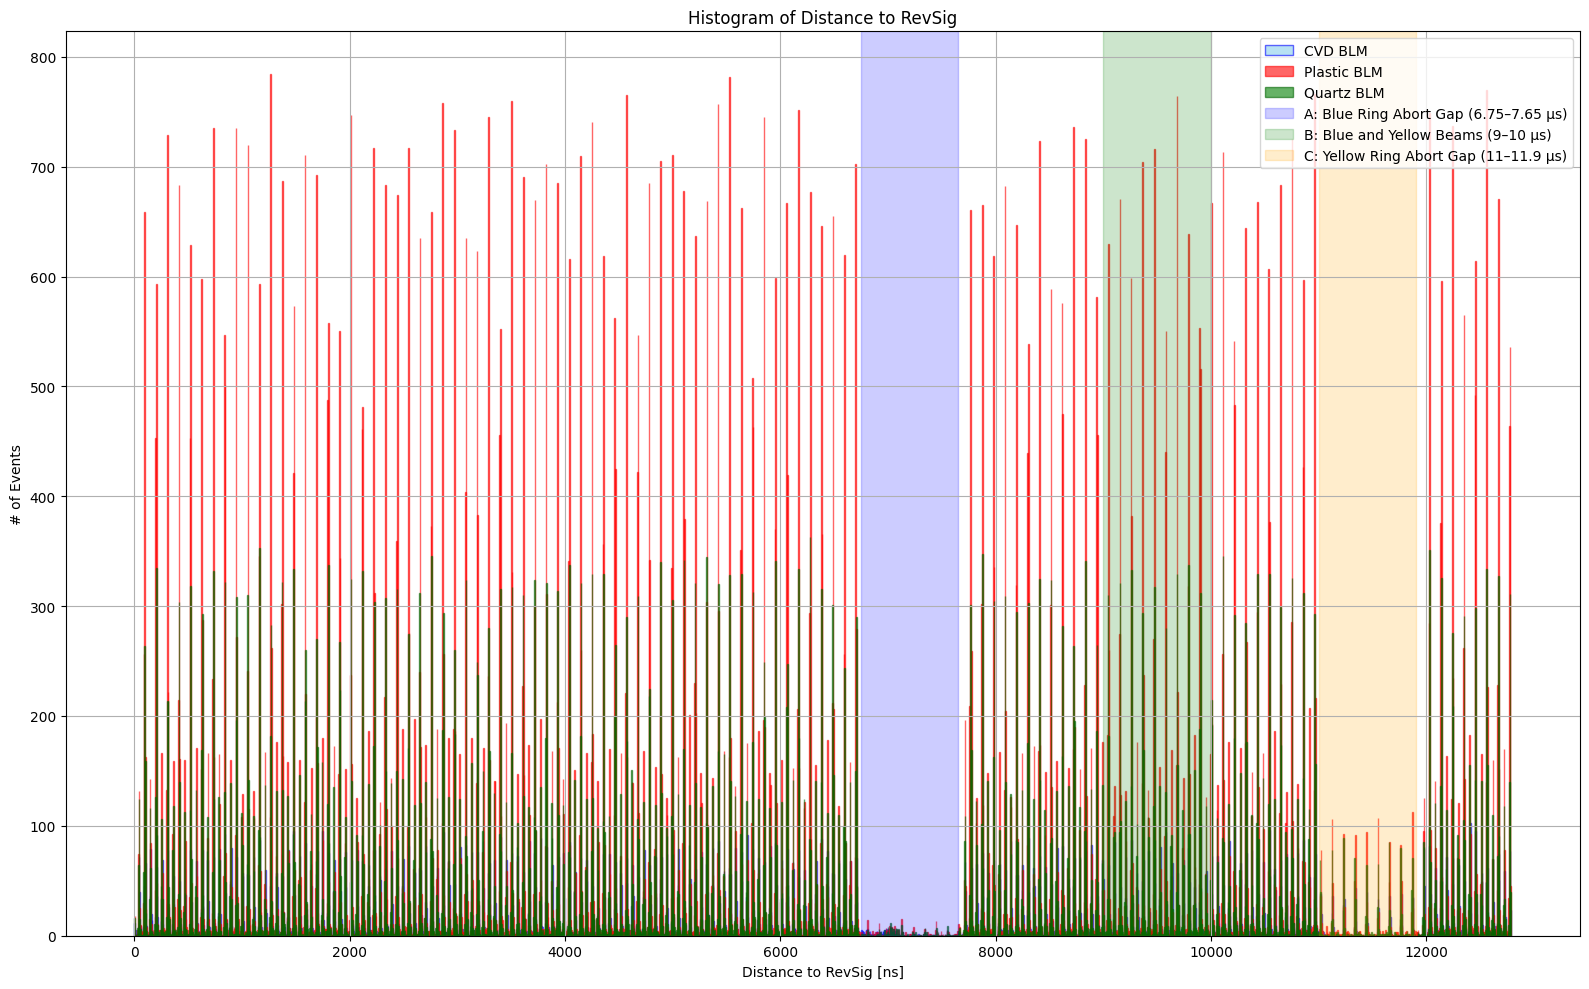

In [195]:
# Plot histogram
plt.figure(figsize=(16, 10))
plt.hist(all_distances_1, bins=2000, color='skyblue', edgecolor=blm_col[1], label=ch_label[1], alpha=0.6)
plt.hist(all_distances_2, bins=2000, color='red'    , edgecolor=blm_col[2], label=ch_label[2], alpha=0.6)
plt.hist(all_distances_3, bins=2000, color='green'  , edgecolor=blm_col[3], label=ch_label[3], alpha=0.6)
# Add shaded boxes for regions A, B, C (convert us to ns)
plt.axvspan(6.75e3, 7.65e3, color='blue',    alpha=0.2, label='A: Blue Ring Abort Gap (6.75–7.65 µs)')
plt.axvspan(9e3, 10e3,     color='green',   alpha=0.2,  label='B: Blue and Yellow Beams (9–10 µs)')
plt.axvspan(11e3, 11.9e3,   color='orange',  alpha=0.2, label='C: Yellow Ring Abort Gap (11–11.9 µs)')

plt.xlabel('Distance to RevSig [ns]')
plt.ylabel('# of Events')
plt.title('Histogram of Distance to RevSig')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/revsig_{date_string}.png", dpi=300)

plt.show()

Zoom in:
- A: 6.75 to 7.6
5 microseconds

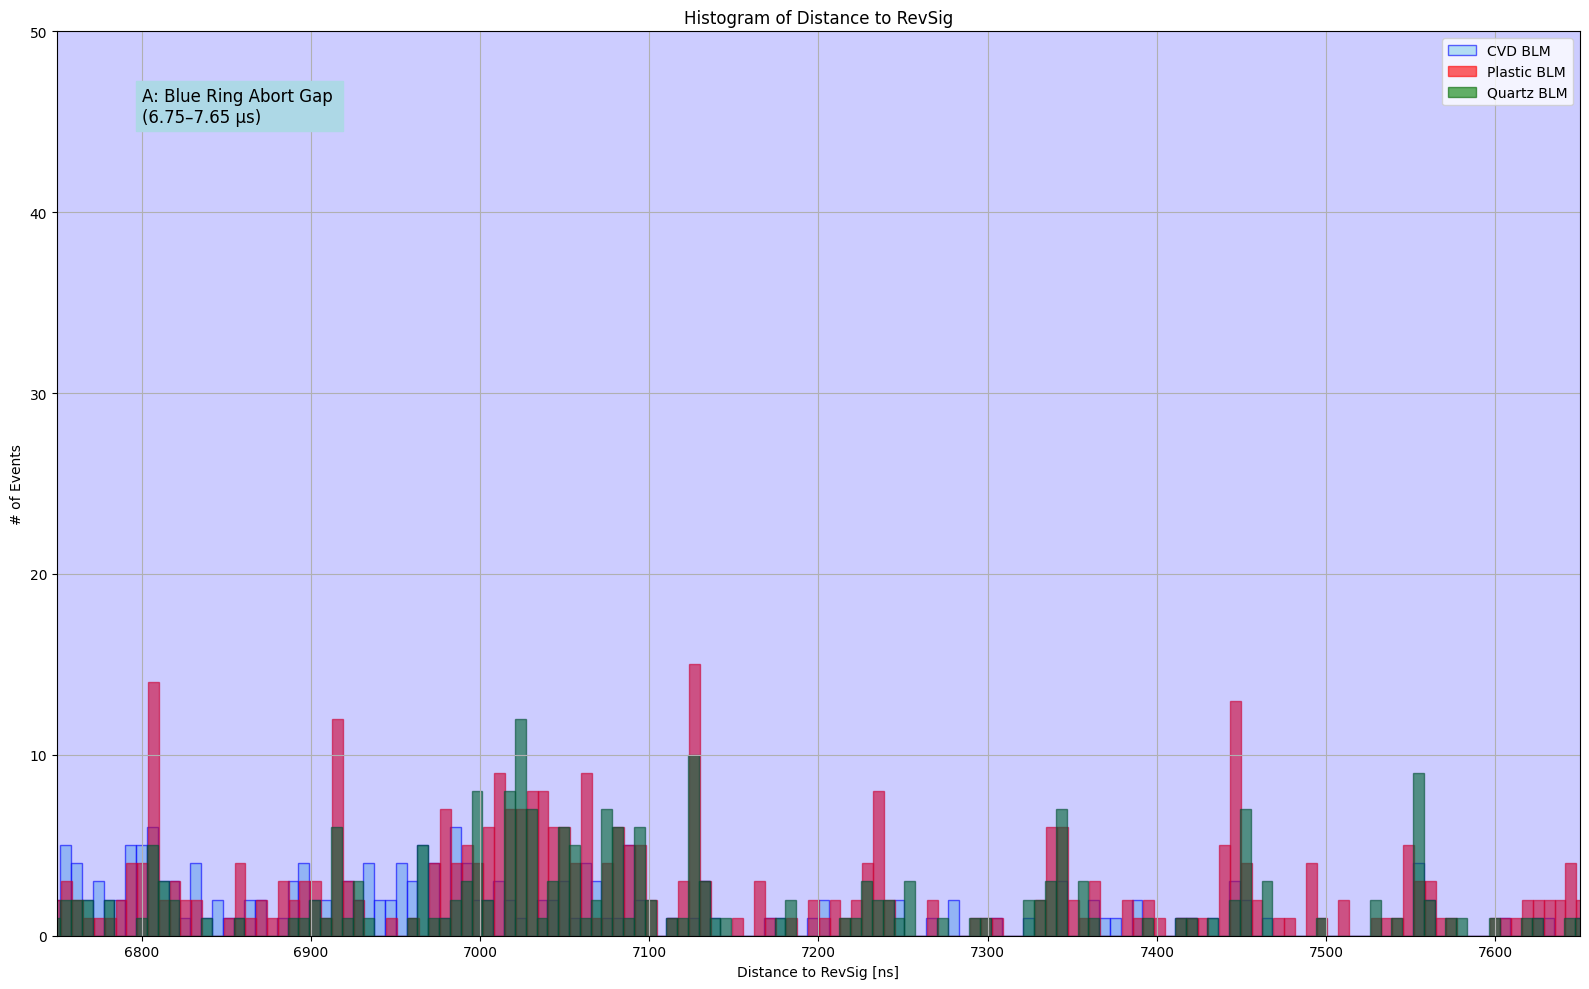

In [196]:
# Plot histogram
fig, ax = plt.subplots(figsize=(16, 10))

# Plot histogram as usual
ax.hist(all_distances_1, bins=2000, color='skyblue', edgecolor=blm_col[1], label=ch_label[1], alpha=0.6)
ax.hist(all_distances_2, bins=2000, color='red', edgecolor=blm_col[2], label=ch_label[2], alpha=0.6)
ax.hist(all_distances_3, bins=2000, color='green', edgecolor=blm_col[3], label=ch_label[3], alpha=0.6)

ax.set_xlim(6750, 7650)
ax.set_ylim(0, 50)
ax.set_xlabel('Distance to RevSig [ns]')
ax.set_ylabel('# of Events')
ax.set_title('Histogram of Distance to RevSig')
# Add the green box
rect = patches.Rectangle((6750, 0), 1000, ax.get_ylim()[1], linewidth=0, facecolor='blue', alpha=0.2)
ax.add_patch(rect)

# Add the label inside the green box
ax.text(6800, ax.get_ylim()[1]*0.9, 'A: Blue Ring Abort Gap \n(6.75–7.65 µs)',
        fontsize=12, color='black', backgroundcolor='lightblue')

ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig(f"./Plots/revsig_{date_string}.png", dpi=300)

plt.show()


- B: 10 to 11 microseconds

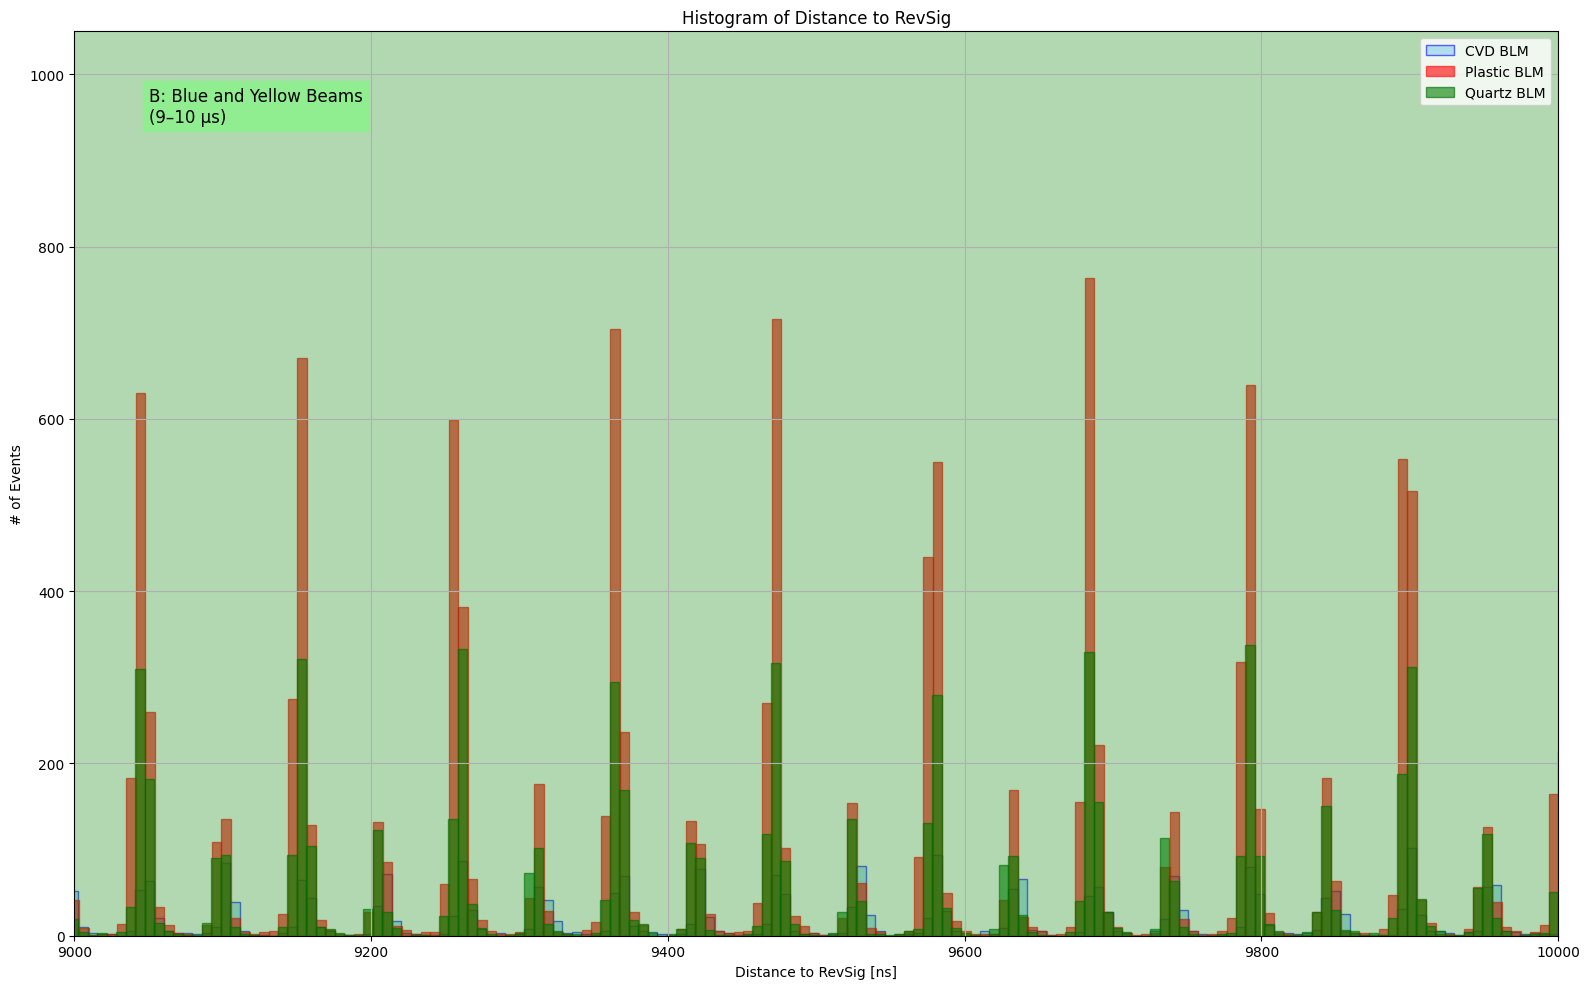

In [197]:
# Plot histogram
fig, ax = plt.subplots(figsize=(16, 10))

# Plot histogram as usual
ax.hist(all_distances_1, bins=2000, color='skyblue', edgecolor=blm_col[1], label=ch_label[1], alpha=0.6)
ax.hist(all_distances_2, bins=2000, color='red', edgecolor=blm_col[2], label=ch_label[2], alpha=0.6)
ax.hist(all_distances_3, bins=2000, color='green', edgecolor=blm_col[3], label=ch_label[3], alpha=0.6)

ax.set_xlim(9000, 10000)
ax.set_ylim(0, 1050)
ax.set_xlabel('Distance to RevSig [ns]')
ax.set_ylabel('# of Events')
ax.set_title('Histogram of Distance to RevSig')
# Add the green box
rect = patches.Rectangle((9000, 0), 1000, ax.get_ylim()[1], linewidth=0, facecolor='green', alpha=0.3)
ax.add_patch(rect)

# Add the label inside the green box
ax.text(9050, ax.get_ylim()[1]*0.9, 'B: Blue and Yellow Beams\n(9–10 µs)',
        fontsize=12, color='black', backgroundcolor='lightgreen')

ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig(f"./Plots/revsig_{date_string}.png", dpi=300)

plt.show()

- C: 11 to 11.9 microseconds

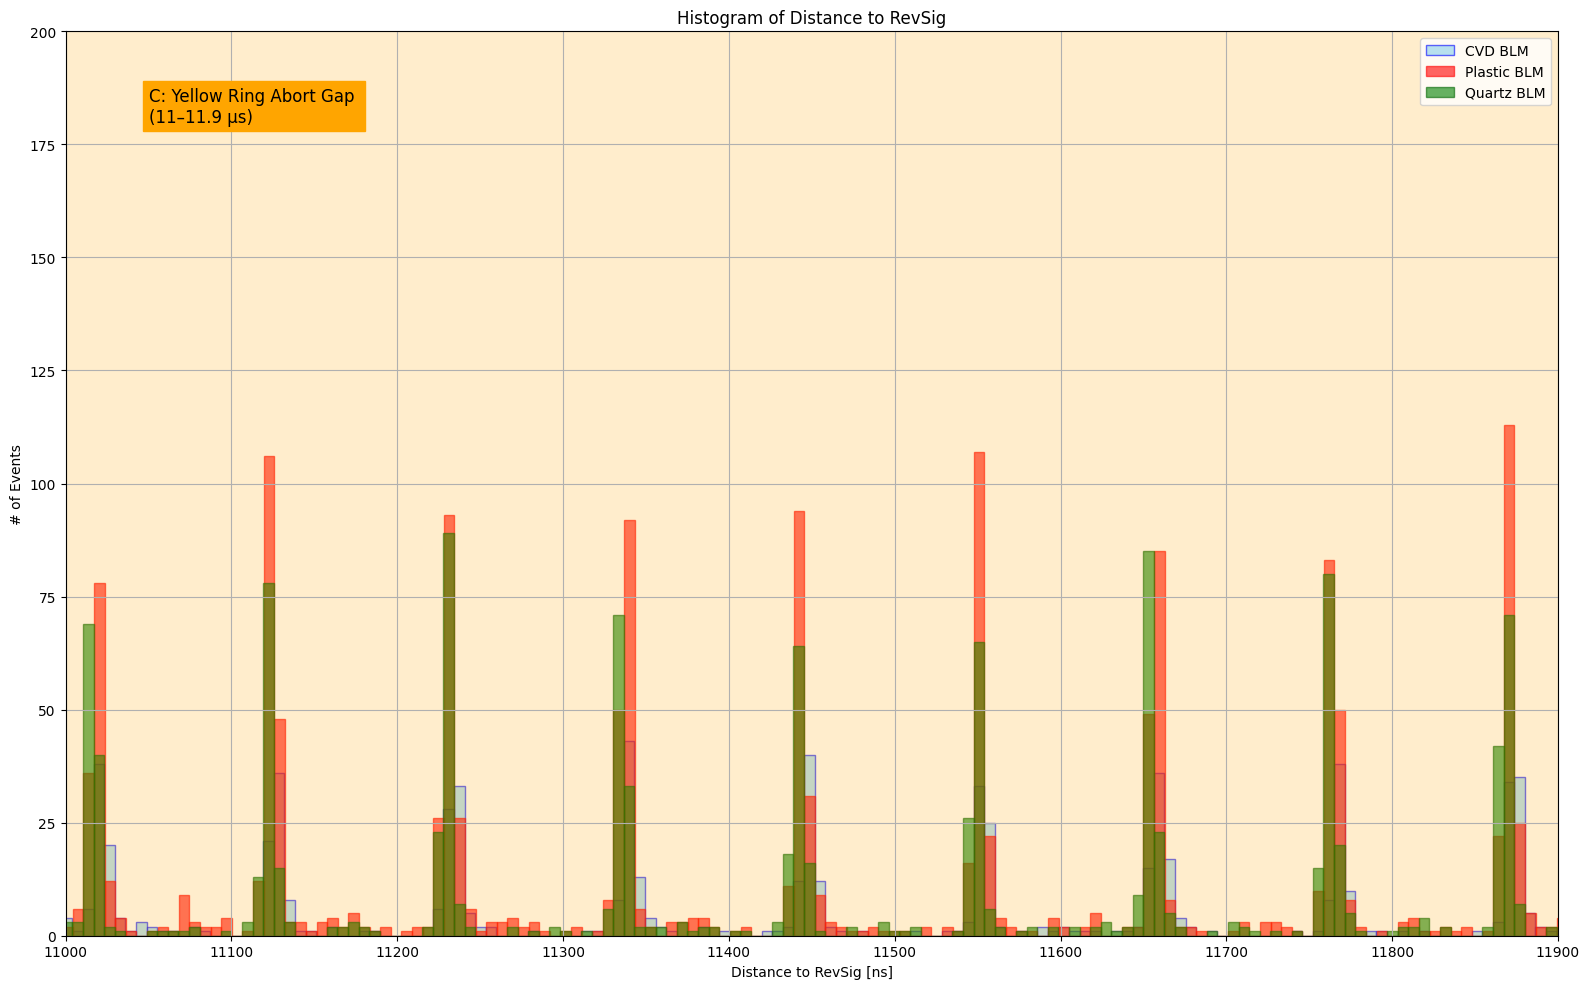

In [198]:
# Plot histogram
fig, ax = plt.subplots(figsize=(16, 10))

# Plot histogram as usual
ax.hist(all_distances_1, bins=2000, color='skyblue', edgecolor=blm_col[1], label=ch_label[1], alpha=0.6)
ax.hist(all_distances_2, bins=2000, color='red', edgecolor=blm_col[2], label=ch_label[2], alpha=0.6)
ax.hist(all_distances_3, bins=2000, color='green', edgecolor=blm_col[3], label=ch_label[3], alpha=0.6)

ax.set_xlim(11e3, 11.9e3)
ax.set_ylim(0, 200)
ax.set_xlabel('Distance to RevSig [ns]')
ax.set_ylabel('# of Events')
ax.set_title('Histogram of Distance to RevSig')
# Add the green box
rect = patches.Rectangle((11e3, 0), 1000, ax.get_ylim()[1], linewidth=0, facecolor='orange', alpha=0.2)
ax.add_patch(rect)

# Add the label inside the green box
ax.text(11050, ax.get_ylim()[1]*0.9, 'C: Yellow Ring Abort Gap \n(11–11.9 µs)',
        fontsize=12, color='black', backgroundcolor='orange')

ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig(f"./Plots/revsig_{date_string}.png", dpi=300)

plt.show()



At STAR IR the detectors see two abort gaps, one for blue and one for yellow beam. The Bunch spacing should be ~106 ns, we see signals from bunches every 106 ns. In addition we see signal every 50 ns, which do not correspond to Beam revolution trigger jitter or detector effects as we use 4 separate detector systems and 2 different readouts.

In [199]:
avg_min = 6 #data taking is N min each, should be >6 minutes
# Count occurrences per N minutes for each channel
counts = df.groupby([
    pd.Grouper(key='timestamp', freq=f'{avg_min}min'),  # round timestamps to avg_min bins
    'ch'
]).size().reset_index(name='count')
# Group and compute mean peak_heights
avg_heights = df.groupby([
    pd.Grouper(key='timestamp', freq=f'{avg_min}min'),
    'ch'
])['peak_heights'].mean().reset_index(name='avg_peak_height')

# Merge rate and average height by time + channel
combined = pd.merge(counts, avg_heights, on=['timestamp', 'ch'], how='left')

# Optional: calculate rate per minute (divide by avg_min)
counts['rate_per_min'] = counts['count'] / (avg_min/3)
counts['rate_per_sec'] = counts['count'] / (avg_min/3*60)
# Optional: calculate rate per minute (divide by avg_min)
combined['rate_per_min'] = combined['count'] / (avg_min/3)
combined['rate_per_sec'] = combined['count'] / (avg_min/3*60)

In [202]:
# Ensure Timestamp is datetime and set index
#df_current['Timestamp'] = pd.to_datetime(df_current['Timestamp'])
#df_current = df_current.set_index('Timestamp')

current = df_current['bluDCCTtotal']
intervals = []

i = 0
while i < len(current) - 1:
    # Find first drop below or equal to 200 from above
    if current.iloc[i] > 210 and current.iloc[i + 1] <= 210:
        drop_200_time = current.index[i + 1]

        # Now look forward for drop below or equal to 50
        j = i + 1
        while j < len(current) and current.iloc[j] > 50:
            j += 1
        if j < len(current):
            drop_50_time = current.index[j]
            intervals.append(
                (drop_200_time,
                drop_50_time)
            )
            i = j  # skip ahead to after this drop
        else:
            break
    else:
        i += 1


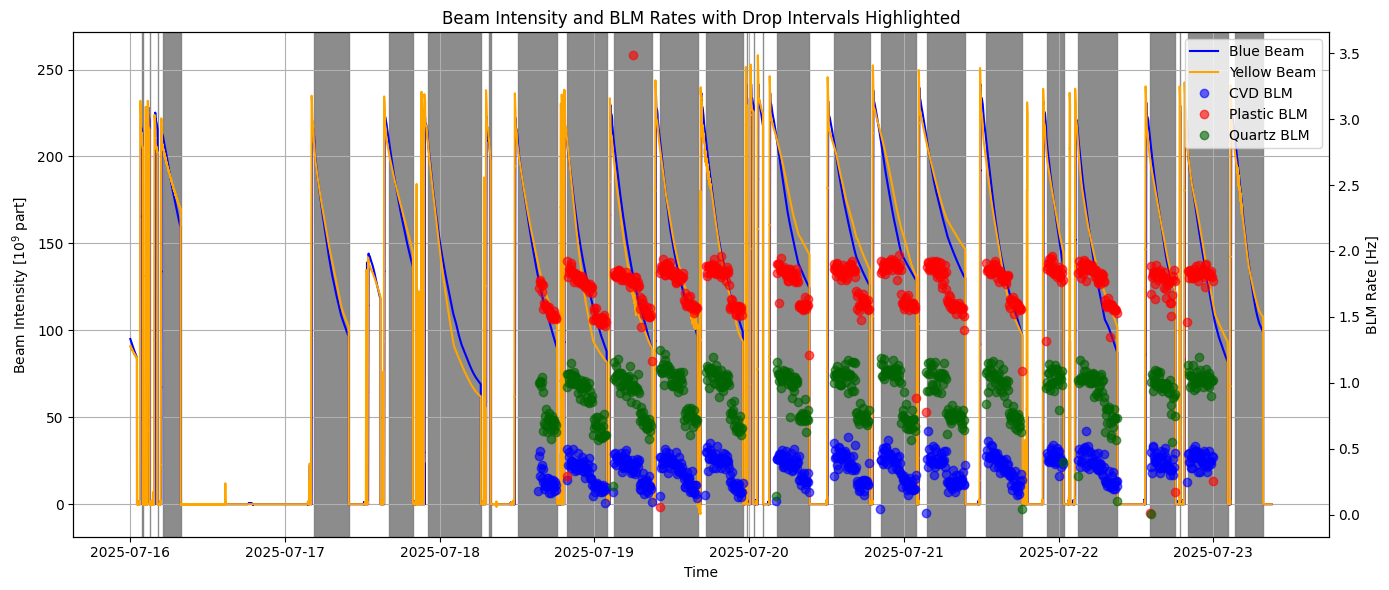

In [203]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left Y-axis (ax1) — Beam Current
ax1.plot(df_current.index, df_current['bluDCCTtotal'], label='Blue Beam', color='blue')
ax1.plot(df_current.index, df_current['yelDCCTtotal'], label='Yellow Beam', color='orange')
ax1.set_ylabel(f'Beam Intensity [$10^{9}$ part]', color='black')

# Highlight intervals on ax1
for start, end in intervals:
    ax1.axvspan(start, end, color='gray', alpha=0.9)

# Right Y-axis (ax2) — Rate per sec
ax2 = ax1.twinx()

for ch in counts['ch'].unique():
    df_ch = counts[(counts['ch'] == ch) & (counts['rate_per_sec'] > 0)]
    ax2.plot(df_ch['timestamp'], df_ch['rate_per_sec'],
             label=ch_label[ch], marker='o', linestyle='', color=blm_col[ch], alpha=0.6)

ax2.set_ylabel('BLM Rate [Hz]', color='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# X-axis and Title
ax1.set_xlabel("Time")
plt.title("Beam Intensity and BLM Rates with Drop Intervals Highlighted")
ax1.grid(True)

plt.tight_layout()
plt.savefig(f"./Plots/stable_beam_intervals_{use_dates}.png", dpi=300)
plt.show()
